In [14]:
using Utils, Plots, LinearAlgebra
using DifferentialEquations
include("./Rocket_Acceleration.jl")
include("./Quaternions.jl")

to_matrix (generic function with 1 method)

In [15]:
module scp_new_problem
include("./6dof fixed t_burn udotdot.jl")
end # module

using .scp_new_problem

In [16]:
solution = scp_new_problem.solve(:ptr); # Remember J is augmented cost function

k  | status   | vd    | vs    | vbc   | J         | ΔJ %      | Δx    | Δu    | Δp    | δ     | dyn | ηx    | ηu    | ηp   
---+----------+-------+-------+-------+-----------+-----------+-------+-------+-------+-------+-----+-------+-------+------
1  | ALMOST_O | 2e-01 | 0e+00 | 1e-08 | 9.76e+00  |           | 8e-02 | 4e-01 | 2e-01 | 2e-01 | T   | 0.12  | 0.40  | 0.16 


2  | ALMOST_O | 2e-03 | 0e+00 | 2e-08 | 4.16e-01  | 95.74     | 1e-02 | 2e-01 | 2e-02 | 4e-02 | T   | 0.40  | 0.24  | 0.03 


3  | ALMOST_O | 8e-06 | 0e+00 | 3e-08 | 3.29e-01  | 20.99     | 2e-03 | 5e-01 | 7e-04 | 3e-03 | T   | 0.01  | 0.46  | 0.00 


4  | ALMOST_O | 3e-06 | 0e+00 | 9e-09 | 3.28e-01  | 0.13      | 1e-03 | 3e-01 | 3e-05 | 1e-03 | T   | 0.02  | 0.33  | 0.00 


5  | ALMOST_O | 3e-06 | 0e+00 | 9e-09 | 3.31e-01  | -0.67     | 2e-04 | 3e-02 | 3e-06 | 2e-04 | T   | 0.31  | 0.05  | 0.00 


6  | ALMOST_O | 1e-07 | 0e+00 | 3e-09 | 3.28e-01  | 0.72      | 1e-05 | 2e-03 | 1e-07 | 1e-05 | T   | 0.01  | 0.00  | 0.00 


7  | ALMOST_O | 6e-07 | 0e+00 | 5e-09 | 3.29e-01  | -0.12     | 2e-05 | 2e-03 | 2e-07 | 2e-05 | T   | 0.05  | 0.01  | 0.00 


8  | ALMOST_O | 4e-07 | 0e+00 | 4e-09 | 3.28e-01  | 0.05      | 2e-05 | 2e-03 | 7e-08 | 2e-05 | T   | 0.03  | 0.01  | 0.00 


Coast time (s): 1.323137698152538
Impact Velocity Magnitude (m/s): 0.5730196915281919


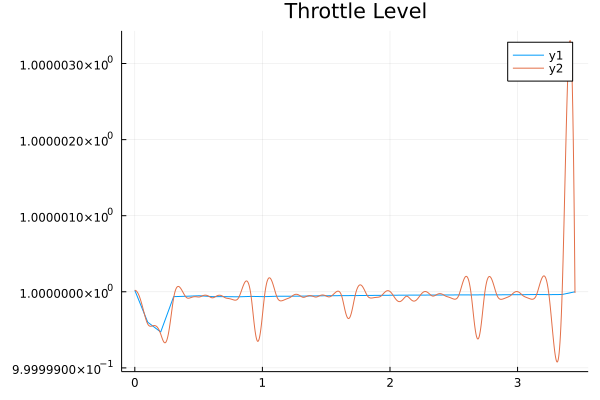

In [17]:
scp_new_problem.print(solution)
scp_new_problem.plot(solution)
# scp_new_problem.save(solution)

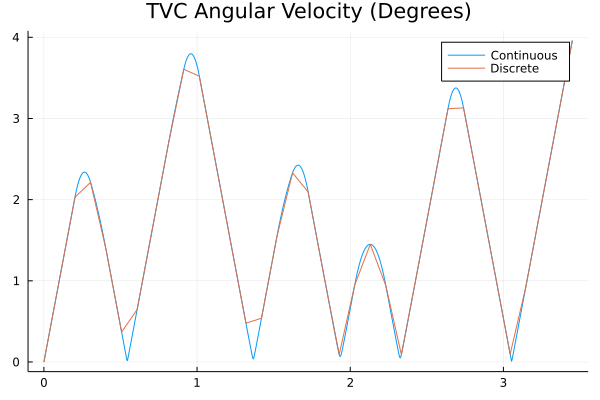

In [18]:
t_burn = 3.45

t_plot = LinRange(0, 1, 1000) * t_burn
Plots.plot(t_plot, [rad2deg(norm(sample(solution.xc, k)[17:19])) for k in t_plot / t_burn], title="TVC Angular Velocity (Degrees)", label = "Continuous")

t_plot = solution.td * t_burn
Plots.plot!(t_plot, [rad2deg(norm(sample(solution.xc, k)[17:19])) for k in t_plot / t_burn], label = "Discrete")

In [100]:
solution.xd[4:6, 1] + Acceleration(dt) * [0; 0; 1] * dt + g * dt

3-element Vector{Float64}:
   4.00000000041058
  -3.0000000006997
 -13.970492391125916

In [122]:
t_burn = 3.45
g = [0; 0; -9.80655]

function f!(dx, x, p, t)
    t_burn = 3.45

    r = x[1:3]
    v = x[4:6]
    quat = x[7:10]
    w = x[11:13]
    T = x[14:16]
    T_dot = x[17:19]

    Control = sample(solution.uc, t / t_burn) # if false, false

    Id = Diagonal([0.2, 0.2, 0.04])
    invId = Diagonal([5.0, 5.0, 25.0])

    dx[1:3] = v
    dx[4:6] = g + rotate(quat, T) * Acceleration(t)
    dx[7:10] = 1/2 * quatL(quat) * [0; w]
    dx[11:13] = invId * ([0; 0; -0.5] × T * Acceleration(t) + [0; 0; Control[4]] - cross(w, Id * w))
    dx[14:16] = T_dot
    dx[17:19] = Control[1:3]
end

prob = ODEProblem(f!, solution.xd[:, 1], (0.0, t_burn))
sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8)

xc = sol(solution.td * t_burn).u
xmatrix = transpose(reduce(hcat, xc))
# plot(xmatrix[:, 1], xmatrix[:, 2], xmatrix[:, 3])
# # plot(sol)

35×19 transpose(::Matrix{Float64}) with eltype Float64:
 25.2926   -7.96941  21.4159      4.0       …   6.68003e-10   4.77792e-9
 25.6984   -8.27383  20.057       4.00009      -0.0106164    -2.02524e-5
 26.1044   -8.57828  18.6467      4.00138      -0.0215179    -0.000138258
 26.5106   -8.88296  17.2378      4.00663      -0.0235801    -0.000290069
 26.9176   -9.18823  15.8899      4.01616      -0.0150405    -0.000268926
 27.3254   -9.49408  14.6595      4.0191    …  -0.00441545   -8.57849e-5
 27.7326   -9.79946  13.5344      4.00243       0.00619045    0.000129377
 28.1368  -10.1026   12.4882      3.95936       0.0167559     0.000284157
 28.535   -10.4013   11.5071      3.88382       0.027207      0.000288753
 28.9237  -10.6929   10.5828      3.77142       0.0374631     2.37151e-5
  ⋮                                         ⋱                
 32.0225  -13.0171    1.0189     -0.176835     -0.0334251     2.42333e-5
 31.9966  -12.9973    0.767579   -0.331419     -0.033811     -0.000266809

In [120]:
# above is same as solution.xc i think.

# xc = [sample(solution.xc, t) for t in solution.td]
# xmatrix = transpose(reduce(hcat, xc));

In [123]:
println(norm(xmatrix - solution.xd', Inf))
println(norm(xmatrix - solution.xd'))

v_N = [0;0;0]
println("Cost: $(norm(xmatrix[end, 4:6] - v_N))")

1.1891712955844935
3.730616621431243
Cost: 1.607943389771854


In [37]:
# solution.xd[17:19, 1] + solution.ud[1:3, 1] * dt + dt^2 /2 * (solution.ud[1:3, 2] - solution.ud[1:3, 1]) / dt
# solution.xd[14:16, 1] + solution.xd[17:19, 1] * dt + solution.ud[1:3, 1] * dt^2/2 + dt^3 / 6 * (solution.ud[1:3, 2] - solution.ud[1:3, 1]) / dt

# solution.ud[1:3, 1] * dt^2/2

In [113]:
# xmatrix - solution.xd'
show(stdout, "text/plain", xmatrix - solution.xd')

35×19 Matrix{Float64}:
  0.0           0.0           0.0           0.0           0.0          0.0           0.0          0.0           0.0           0.0           0.0           0.0          0.0           0.0           0.0           0.0          0.0           0.0          0.0
  8.08953e-12  -5.96678e-12  -2.64059e-10  -3.59297e-10   6.44052e-10  2.38392e-10   1.06501e-8  -4.48984e-12  -1.03353e-10   4.28224e-12  -5.12178e-10  -1.8923e-10  -1.16462e-13  -4.4583e-10   -6.62088e-10  -2.4195e-8   -9.16094e-11  -4.14428e-10  1.89129e-9
  3.94223e-10  -2.94401e-10   2.83029e-7    7.16915e-9   -5.42471e-9   5.34454e-6    1.08853e-8  -5.95025e-10  -7.81045e-10   6.93353e-12  -1.79371e-8   -2.04442e-8   2.84126e-13  -4.63062e-10  -1.26823e-9   -2.55354e-8  -1.96197e-10  -6.14894e-10  4.20766e-9
  2.73844e-9   -2.14433e-9    1.37534e-6    3.58935e-8   -2.83408e-8   1.45476e-5    1.11076e-8  -3.57352e-9   -4.38951e-9    6.97909e-12  -9.48414e-8   -1.15477e-7   3.84437e-13  -4.80327e-10  -1.71549e-

-9.63849e-8  -6.23327e-7   -7.71884e-7   -1.39097e-9   -9.95688e-7   -1.16366e-6  -1.54067e-10  -1.37762e-9   -1.02113e-9   -1.25654e-8  -1.27268e-9    9.72814e-10  3.74428e-9
 -6.02408e-6    4.74215e-6    8.82922e-5   -1.53986e-5    1.22067e-5   7.01695e-5   -1.04833e-7  -6.73577e-7   -8.30465e-7   -1.91139e-9   -9.99451e-7   -1.15861e-6  -1.53541e-10  -1.59562e-9   -8.88681e-10  -1.21804e-8  -1.32711e-9    9.32474e-10  3.74289e-9
 -7.70524e-6    6.07715e-6    9.5377e-5    -1.77623e-5    1.41282e-5   6.94835e-5   -1.11059e-7  -7.24126e-7   -8.88929e-7   -2.49678e-9   -1.00252e-6   -1.15277e-6  -1.53959e-10  -1.8284e-9    -7.85274e-10  -1.18052e-8  -1.33069e-9    8.78626e-10  3.74337e-9
 -9.61187e-6    7.59722e-6    0.000102269  -2.00346e-5    1.59993e-5   6.74374e-5   -1.15587e-7  -7.75585e-7   -9.48158e-7   -3.14982e-9   -1.01855e-6   -1.16403e-6  -1.52592e-10  -2.05204e-9   -7.10416e-10  -1.14208e-8  -1.28163e-9    8.1898e-10   3.74296e-9
 -1.17786e-5    9.33026e-6    0.000109075  -

In [39]:
count(abs.(norm.(eachcol(solution.xd[7:10, :]))) .- 1 .> 1e-6) # check if quat norm is within 1e-6 of 1.

0